# MNIST convolutional neural networks with train validation split

* MNIST data를 가지고 softmax classifier를 만들어보자.
* train data, validation data를 구분하여 model을 training하자
  + train data : model을 training 시키는 데 사용
  + validation data : training에 이용하지않은 data, model을 validation 하는 데 활용 (보통 1 epoch마다)
* [`tf.contrib.slim`](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/slim) 참고
* [02_mnist_cnn_with_slim.ipynb](https://nbviewer.jupyter.org/github/modulabs/modu-tensorflow/blob/master/week03/02_mnist_cnn_with_slim.ipynb)를 기반으로 refactoring

### Import modules

In [1]:
"""A LeNet-5 like cnn MNIST classifier.
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

slim = tf.contrib.slim

sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))

#np.random.seed(219)
#tf.set_random_seed(219)

Instructions for updating:
Use the retry module or similar alternatives.


### Import data

In [2]:
# Load training and test data from tf.keras
(x_train, y_train), (x_test, y_test) = \
    tf.keras.datasets.mnist.load_data()

x_train = x_train / 255.
x_train = x_train.astype(dtype = np.float32)
y_train = np.asarray(y_train, dtype=np.int32)

x_test = x_test / 255.
x_test = x_test.astype(np.float32)
y_test = np.asarray(y_test, dtype=np.int32)

In [11]:
print(type(x_train))

<class 'numpy.ndarray'>


In [22]:
x_test.shape

(10000, 28, 28)

### Split data

In [4]:
x_train.shape

(60000, 28, 28)

In [7]:
np.random.choice(10, size = 5, replace = False)

array([7, 6, 4, 3, 8])

In [8]:
tr_indices

array([55596,  5693, 58890, ..., 10379, 27088, 26858])

In [14]:
np.delete(np.arange(5), [2,3], axis=0)

array([0, 1, 4])

In [3]:
# x_train에서 training에 쓸 index 50000개 가져옴
tr_indices = np.random.choice(np.arange(x_train.shape[0]), size = 50000, replace = False)

# model training에 이용할 data
x_tr = x_train[tr_indices]
y_tr = y_train[tr_indices]

# epoch 마다 model validation에 이용할 data
x_val = np.delete(arr = x_train, obj = tr_indices, axis = 0)
y_val = np.delete(arr = y_train, obj = tr_indices, axis = 0)

print('for training {}, {}'.format(x_tr.shape, y_tr.shape))
print('for validation {}, {}'.format(x_val.shape, y_val.shape))

for training (50000, 28, 28), (50000,)
for validation (10000, 28, 28), (10000,)


### Set up dataset with `tf.data`

#### create input pipeline with `tf.data.Dataset` to train and validation data

In [15]:
batch_size = 32

# for training
tr_dataset = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
tr_dataset = tr_dataset.shuffle(buffer_size = 10000)
tr_dataset = tr_dataset.batch(batch_size = batch_size)
tr_iterator = tr_dataset.make_initializable_iterator()

print(tr_dataset)

# for validation
# validation data의 용량이 in memory에 넣을 수 없을정도로 아래와 같이 활용한다.
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.shuffle(buffer_size = 10000)
val_dataset = val_dataset.batch(batch_size = batch_size)
val_iterator = val_dataset.make_initializable_iterator()

print(val_dataset)

<BatchDataset shapes: ((?, 28, 28), (?,)), types: (tf.float32, tf.int32)>
<BatchDataset shapes: ((?, 28, 28), (?,)), types: (tf.float32, tf.int32)>


#### Define Iterator

In [16]:
# tf.data.Iterator.from_string_handle의 output_shapes는 default = None이지만 꼭 값을 넣는 게 좋음
handle = tf.placeholder(tf.string)
iterator = tf.data.Iterator.from_string_handle(handle,
                                               tr_dataset.output_types,
                                               tr_dataset.output_shapes)
x, y = iterator.get_next()

### Create the model

In [17]:
def cnn_model_fn(x):
    """"Model function for CNN.
    Args:
        x: input images
        mode: boolean whether trainig mode or test mode
    Returns:
    logits: unnormalized score funtion
  """
    # Input Layer
    # Reshape X to 4-D tensor: [batch_size, width, height, channels]
    # MNIST images are 28x28 pixels, and have one color channel
    
    with tf.name_scope('reshape'):
        x_image = tf.reshape(x, [-1, 28, 28, 1])
        
    # Convolutional Layer #1
    # Input Tensor Shape: [batch_size, 28, 28, 1]
    # Output Tensor Shape: [batch_size, 28, 28, 32]
    conv1 = slim.conv2d(x_image, 32, [5, 5], scope='conv1')

    # Pooling Layer #1
    # Input Tensor Shape: [batch_size, 28, 28, 32]
    # Output Tensor Shape: [batch_size, 14, 14, 32]
    pool1 = slim.max_pool2d(conv1, [2, 2], scope='pool1')
  
    # Convolutional Layer #2
    # Input Tensor Shape: [batch_size, 14, 14, 32]
    # Output Tensor Shape: [batch_size, 14, 14, 64]
    conv2 = slim.conv2d(pool1, 64, [5, 5], scope='conv2')

    # Pooling Layer #2
    # Second max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 14, 14, 64]
    # Output Tensor Shape: [batch_size, 7, 7, 64]
    pool2 = slim.max_pool2d(conv2, [2, 2], scope='pool2')

    # Flatten tensor into a batch of vectors
    # Input Tensor Shape: [batch_size, 7, 7, 64]
    # Output Tensor Shape: [batch_size, 7 * 7 * 64]
    pool2_flat = slim.flatten(pool2, scope='flatten')
  
    # Fully connected Layer
    # Input Tensor Shape: [batch_size, 7 * 7 * 64]
    # Output Tensor Shape: [batch_size, 1024]
    fc1 = slim.fully_connected(pool2_flat, 1024, scope='fc1')

    # Add dropout operation; 0.6 probability that element will be kept
    is_training = tf.placeholder(tf.bool)
    fc1_drop = slim.dropout(fc1, keep_prob=0.6, is_training=is_training, scope='dropout')

    # Logits layer
    # Input Tensor Shape: [batch_size, 1024]
    # Output Tensor Shape: [batch_size, 10]
    logits = slim.fully_connected(fc1_drop, 10, activation_fn=None, scope='logits')
  
    return logits, is_training, x_image

### Build the model

In [18]:
logits, is_training, x_image = cnn_model_fn(x)

### Define loss and optimizer

In [19]:
cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=logits)
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

### `tf.Session()` and train

In [20]:
sess = tf.Session(config=sess_config)
sess.run(tf.global_variables_initializer())

# history
tr_hist = []
val_hist = []

# Generate handles of tr_iterator and val_iterator
tr_handle, val_handle = sess.run(fetches = [tr_iterator.string_handle(), val_iterator.string_handle()])

# Train
max_epochs = 5

for epoch in range(max_epochs):
    
    avg_tr_loss = 0
    avg_val_loss = 0
    tr_step = 0
    val_step = 0
    
    # training 1-epoch
    sess.run(tr_iterator.initializer)
    while True:
        try:
            _, tr_loss = sess.run(fetches = [train_step, cross_entropy],
                               feed_dict = {handle : tr_handle, is_training : True})
            tr_step += 1
            avg_tr_loss += tr_loss

        except tf.errors.OutOfRangeError:
            break
    
    # validation 1-epoch
    sess.run(val_iterator.initializer)
    while True:
        try:
            val_loss = sess.run(cross_entropy, 
                                feed_dict = {handle : val_handle, is_training : False})
            val_step += 1
            avg_val_loss += val_loss
        
        except tf.errors.OutOfRangeError:
            break
            
    avg_tr_loss /= tr_step
    avg_val_loss /= val_step
    tr_hist.append(avg_tr_loss)
    val_hist.append(avg_val_loss)
    
    print('epochs : {:3}, tr_loss : {:.3f}, val_loss : {:.3f}'.format(epoch + 1, avg_tr_loss, avg_val_loss))

epochs :   1, tr_loss : 0.262, val_loss : 0.084
epochs :   2, tr_loss : 0.079, val_loss : 0.053
epochs :   3, tr_loss : 0.056, val_loss : 0.048
epochs :   4, tr_loss : 0.043, val_loss : 0.037
epochs :   5, tr_loss : 0.035, val_loss : 0.034


### Test trained model

In [21]:
yhat = sess.run(logits, feed_dict = {x : x_test, is_training : False})
yhat = np.argmax(yhat, axis = 1)

In [23]:
yhat.shape

(10000,)

In [24]:
yhat

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

In [25]:
print('test accuracy : {:.2%}'.format(np.mean(yhat == y_test)))

test accuracy : 98.97%


### Visualize history

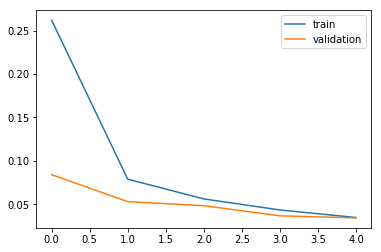

In [26]:
plt.plot(tr_hist, label = 'train')
plt.plot(val_hist, label = 'validation')
plt.legend()